# MY NOTEBOOK

## CONFIG

In [1]:
%load_ext autoreload
%autoreload

### Imports

In [2]:
import os
import fnmatch
import re
import random
import time
import sys

import librosa
import tensorflow as tf

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt 

import itertools

#import progressbar
from time import sleep

from models import *

ImportError: No module named 'progressbar'

## Constants

### Local Machine

In [ ]:
MTT_DIR = "../MTT/"
DATA_DIRECTORY = MTT_DIR + "dataset/"
# CSV containing song details (title, artist, id, mp3_path,...)
CLIP_INFO_FINAL = "clip_info_final.csv"
# CSV containg the labels (clip_id, labels, mp3_path)
ANNOTATIONS_FINAL = "annotations_final.csv"
# CSV : what is it useful for ?
COMPARISONS_FINAL = "comparisons_final.csv"
LABELS_FILE = MTT_DIR + ANNOTATIONS_FINAL

SUB_DIRS = "0123456789abcdef"

AUDIO1_path = "../MTT/mtt_data_mp3.zip/0/american_bach_soloists-j_s__bach_\
_transcriptions_of_italian_music-02-concerto_in_a_minor_for_four_harpsichords\
_bwv_1065_ii_largo-88-117.mp3"

### LTS2 Server

In [ ]:
MTT_DIR = "/mnt/scratch/students/jjgweber-MagnaTagATune/"
DATA_DIRECTORY = MTT_DIR + "dataset/"

# CSV containg the labels (clip_id, labels, mp3_path)
ANNOTATIONS_FINAL = "annotations_final.csv"

LABELS_FILE = MTT_DIR + ANNOTATIONS_FINAL

SUB_DIRS = "0123456789abcdef"

In [4]:
FILE_NB = 25880 #25863
FILE_LENGTH = 465984
# 465984 = 2 × 2 × 2 × 2 × 2 × 2 × 3 × 3 × 809
# useful for batches > for now divide by 9 (instead of 10)

BATCH_NB = 9
BATCH_SIZE = int(FILE_LENGTH/BATCH_NB)
SAMPLE_SIZE = 0
SAMPLE_RATE = 16000
RECEPTIVE_FIELD = 0

BASIC_CONFIG ={'numOutputNeurons':500}
LEARNING_RATE = 0.001

In [20]:
# Variables which are often modified to test the algorithm
NB_SONGS = 258
EPOCHS = 80 # check in paper
LABELS_NAME = ['guitar', 'techno']
NB_LABELS = len(LABELS_NAME)

## Loading tool functions

In [6]:
def load_labels(labels_file_name):
    pd.read_csv(labels_file_name)

def randomize_files(files):
    for file in files:
        file_index = random.randint(0, (len(files) - 1))
        yield files[file_index]


def find_files(directory, pattern='*.mp3', sample=None):
    '''Recursively finds all files matching the pattern.'''
    files = []
    for root, dirnames, filenames in os.walk(directory):
        for filename in fnmatch.filter(filenames, pattern):
            files.append(os.path.join(root, filename))
    if sample!=None :
        try:
            return files[:sample]
        except TypeError:
            print("Argument sample should be either None, or an integer :\
             the number of first n samples to take.")
    else :
        return files

## Prediction labels

### Load and clean

In [7]:
labels = pd.read_csv(LABELS_FILE, sep = '"\t"')

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  """Entry point for launching an IPython kernel.


In [8]:
# Prepare header to put back in the end
# remove quotes and take all columns except the first one
header = list(map(lambda x : x.replace('"', ''), labels))[1:]
# add back the first column, separated in two
header = ['clip_id', 'no_voice']+header
# create dictionary
header = dict(enumerate(header))

In [9]:
# Solve format problem : two first columns are merged
# extract first column and rest
left, right = labels['"clip_id\t""no voice"'], labels.iloc[:, 1:]
# split first column in two part at separator "\t"
split = left.str.split(pat = "\t", expand=True).replace('"', '')

# put back the first column which is now two, with the rest
cleaned = pd.concat([split, right], axis=1, ignore_index=True) 
# clean by removing quotes and add back header
cleaned = cleaned.apply(lambda col : col.apply(lambda x : x.replace('"', ''))).rename(columns = header)
cleaned.head(5)

,clip_id,no_voice,singer,duet,plucking,hard rock,world,bongos,harpsichord,female singing,...,rap,metal,hip hop,quick,water,baroque,women,fiddle,english,mp3_path
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,f/american_bach_soloists-j_s__bach_solo_cantat...
1,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,f/american_bach_soloists-j_s__bach_solo_cantat...
2,10,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,f/american_bach_soloists-j_s__bach_solo_cantat...
3,11,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,f/american_bach_soloists-j_s__bach_solo_cantat...
4,12,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,f/american_bach_soloists-j_s__bach_solo_cantat...


### Analyse the dataset

In [10]:
## TODO : Some statistics on the MTT dataset ?
nb_labels_per_song = cleaned.iloc[:,1:-1].astype(int).sum(axis=1)
nb_song_per_label = cleaned.iloc[:,1:-1].astype(int).sum(axis=0)
nb_song_per_label.sort_values(ascending=False)

guitar             4852
classical          4272
slow               3547
techno             2954
strings            2729
drums              2598
electronic         2519
rock               2371
fast               2306
piano              2056
ambient            1956
beat               1906
violin             1826
vocal              1729
synth              1717
female             1474
indian             1395
opera              1296
male               1279
singing            1211
vocals             1184
no vocals          1158
harpsichord        1093
loud               1086
quiet              1055
flute              1025
woman              1016
male vocal         1002
no vocal            995
pop                 995
                   ... 
not opera            61
not classical        61
not rock             59
clapping             59
horn                 59
acoustic guitar      58
disco                57
orchestral           56
no strings           56
old                  55
echo            

In [11]:
# label header is the header without clip_id and mp3_path > length 188 instead of 190
label_header = np.asarray(list(header.values()))[1:-1]

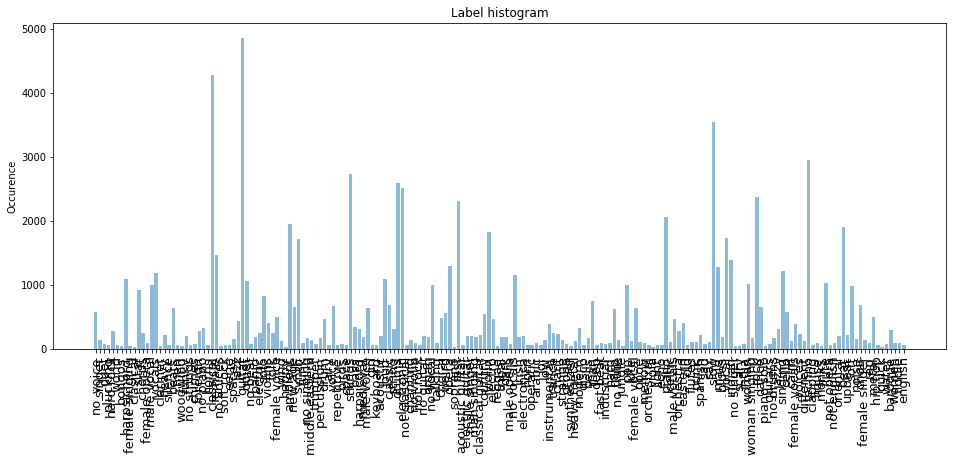

In [12]:
fig = plt.figure(figsize=(16,6))

y_pos = np.arange(len(nb_song_per_label))
plt.bar(y_pos, nb_song_per_label, align='center', alpha=0.5)
plt.xticks(y_pos, nb_song_per_label)
plt.ylabel('Occurence')
plt.title('Label histogram')
plt.xticks(np.arange(len(label_header)), label_header, rotation=90, fontsize = 13)

plt.show()

In [13]:
# Find the most frequent labels to start with for training

for i in range(len(nb_song_per_label)) :
    if nb_song_per_label[i] > 1000:
        print(i, "> ", label_header[i], " -- ", nb_song_per_label[i])

7 >  harpsichord  --  1093
13 >  male vocal  --  1002
14 >  vocals  --  1184
27 >  classical  --  4272
28 >  female  --  1474
34 >  guitar  --  4852
35 >  quiet  --  1055
45 >  ambient  --  1956
47 >  synth  --  1717
59 >  strings  --  2729
67 >  loud  --  1086
70 >  drums  --  2598
71 >  electronic  --  2519
82 >  opera  --  1296
84 >  fast  --  2306
91 >  violin  --  1826
97 >  no vocals  --  1158
132 >  piano  --  2056
143 >  slow  --  3547
144 >  male  --  1279
146 >  vocal  --  1729
147 >  indian  --  1395
151 >  woman  --  1016
153 >  rock  --  2371
159 >  singing  --  1211
165 >  techno  --  2954
169 >  flute  --  1025
173 >  beat  --  1906


In [14]:
print("Number of songs : " , cleaned.shape[0])
print("Number of labels : " , cleaned.shape[1])
print("Max number of songs tagged with the same label : ",max(nb_song_per_label))
print("Max number of labels for a single song : ",max(nb_labels_per_song))

Number of songs :  25863
Number of labels :  190
Max number of songs tagged with the same label :  4852
Max number of labels for a single song :  27


## Load and format mp3 data 

In [21]:
# TODO : not efficient to 
# - give the whole label dataset to the function as argument
# - look in the label dataset at each iteration to retrieve the label
#   > should concat before randomize
# - append to an array and then convert to numpy ? > check

# labels_name : liste of columns name which we want to load

def load_audio_label(labels, directory, sample_rate, num_songs, labels_name=LABELS_NAME):
    files = find_files(directory, sample=num_songs)
    randomized_files = randomize_files(files)
    count = 0
    audios = np.ndarray(shape=(num_songs, BATCH_NB, BATCH_SIZE, 1), dtype=np.float32, order='F')
    tags = np.ndarray(shape=(num_songs, BATCH_NB, NB_LABELS), dtype=np.float32, order='F')
    
    for filename in randomized_files:

        # Load MP3 file        
        try :
            audio, _ = librosa.load(filename, sr=sample_rate, mono=True)
        except EOFError :
            print("EOFERROR : The following file could not be loaded with librosa - ", filename)

        audio = audio.reshape(-1, 1)

        #create batches
        audio_batch = np.ndarray(shape=(BATCH_NB, BATCH_SIZE, 1), dtype=np.float32, order='F')
        label_batch = np.ndarray(shape=(BATCH_NB, NB_LABELS), dtype=np.float32, order='F')
        for n in range(BATCH_NB) :
            audio_batch[n] = audio[n*BATCH_SIZE: (n+1)*BATCH_SIZE,:]
            
            # take labels or corresponding mp3 song
            select_labels  = labels.loc[labels['mp3_path']==filename[len(DATA_DIRECTORY):]]

            # select wanted labels
            select_labels = select_labels[labels_name]

            label_batch[n] = select_labels.values.reshape(NB_LABELS)
        
        audios[count] = audio_batch
        tags[count] = label_batch
        
        count +=1
        if (count % 10) == 0:
            print(count)

    return audios, tags

In [22]:
# load audios and labels > convert to numpy
# CAREFUL : the argument num_songs is important and shouldn't be too big 
# > otherwise MEMORY ISSUES !!!!!!
start = time.time()
audios, tags = load_audio_label(cleaned, DATA_DIRECTORY, None, num_songs = NB_SONGS)
end = time.time()
length = end-start
print(length)

10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
11.68430781364441


In [17]:
print("Shape of audios list :")
print(audios.shape)
print()
print(">> shape is : [num_song, num_batches, batch_size, 1]")


Shape of audios list :
(6, 9, 51776, 1)

>> shape is : [num_song, num_batches, batch_size, 1]


In [18]:
print("Shape of tags list :")
print(tags.shape)
print()
print(">> shape is : [num_song, num_labels (mp3 file and id excluded), 1] ")
print("(or : [num_song, num_labels, 1, str_len, 1])")

Shape of tags list :
(6, 9, 2)

>> shape is : [num_song, num_labels (mp3 file and id excluded), 1] 
(or : [num_song, num_labels, 1, str_len, 1])


In [19]:
# put all batches at the same level (remove song dimension in the array)
# ex : go from dimensions (n, m, k, 1) > to (n*m, k, 1)
audios_flatten = audios.reshape(-1, audios.shape[-2], audios.shape[-1])
tags_flatten = tags.reshape(-1, tags.shape[-1])

## Neural Network model

In [20]:
# run this cell everytime before relaunching tensorflow session
tf.reset_default_graph()

In [21]:
audio_tf= tf.convert_to_tensor(audios_flatten, np.float32)
print(audio_tf.shape)

net = build_model(audio_tf, is_training=True, config=BASIC_CONFIG) 
prediction = tf.layers.dense(net, NB_LABELS, activation=tf.sigmoid)
loss = tf.nn.sigmoid_cross_entropy_with_logits(labels = tags_flatten, logits = prediction)
reduced_loss = tf.reduce_mean(loss)
train_op = tf.train.AdamOptimizer(learning_rate=LEARNING_RATE).minimize(reduced_loss)

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for i in range(EPOCHS):
        _, loss_value = sess.run([train_op, reduced_loss])
        print("Iter: {}, Loss: {:.4f}".format(i, loss_value))


(54, 51776, 1)
Iter: 0, Loss: 0.9556
Iter: 1, Loss: 0.9246
Iter: 2, Loss: 0.8846
Iter: 3, Loss: 0.8444
Iter: 4, Loss: 0.8264
Iter: 5, Loss: 0.8034
Iter: 6, Loss: 0.7850
Iter: 7, Loss: 0.7633
Iter: 8, Loss: 0.7522
Iter: 9, Loss: 0.7419
Iter: 10, Loss: 0.7326
Iter: 11, Loss: 0.7238
Iter: 12, Loss: 0.7175
Iter: 13, Loss: 0.7134
Iter: 14, Loss: 0.7109
Iter: 15, Loss: 0.7083
Iter: 16, Loss: 0.7066
Iter: 17, Loss: 0.7056
Iter: 18, Loss: 0.7028
Iter: 19, Loss: 0.7015
Iter: 20, Loss: 0.7007
Iter: 21, Loss: 0.7002
Iter: 22, Loss: 0.6993
Iter: 23, Loss: 0.6983


KeyboardInterrupt: 